In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2, chi2_contingency
from scipy import stats

In [2]:
sns.__version__

'0.11.0'

In [3]:
data_path = os.path.join(os.getcwd(), 'data', 'PCS_TEST_DETERMINSTIC.xls')
df = pd.read_excel(data_path, sheet_name="Sheet1")

In [4]:
df.head()

,Arrival no,Arrival time (sec),Base station,Call duration (sec),velocity (km/h),Inter-arrival (sec),velocity (km/s)
0,1,0.000000,18,76.133611,125.934254,0.067744,0.034982
1,2,0.067744,7,159.056244,95.510881,0.491441,0.026531
2,3,0.559184,6,179.465053,127.757456,0.066135,0.035488
3,4,0.625319,14,163.108320,134.310552,0.719747,0.037308
4,5,1.345066,2,95.054472,112.272359,0.242954,0.031187


## Statistical Tests for Hypothetical Distributions
Due to ease of use, we will be using the KS test as opposed to the ChiSquare test.
However, it should be noted that the KS test in general, makes use of the cummulative distribution function (CDF), to gauge the distance between 2 distributions, i.e. our empirical distribution and theoretical distribution.
### Distinction
In the lectures, we applied a specialised case of the KS test. We first stated that exponentially distributed interarrival times will have uniformly distributed arrival times. The KS test then computed the "distance" between the CDF of our data and the uniform distribution that would be theoretically obtained. 

When using `scipy.stats.kstest`, we instead directly compute the "distance" between our empirical distribution and our distribution of choice directly.

In [5]:
df["Inter-arrival (sec)"][:-1].describe()
# MLE beta=1.369817
beta = 1.369817

In [6]:
def expcdf(x, beta=1.0):
    return 1.0 - np.exp(-x/beta)
# dist = stats.expon
# args = dist.fit(df["Inter-arrival (sec)"][:-1])
# args
# np.isnan(df["Inter-arrival (sec)"][:-1])
stats.kstest(df["Inter-arrival (sec)"][:-1], expcdf, (beta,))

KstestResult(statistic=0.010023150692294924, pvalue=0.2658106043225813)

In [7]:
dist = stats.expon
args = dist.fit(df["Inter-arrival (sec)"][:-1])
print(args)
# np.isnan(df["Inter-arrival (sec)"][:-1])
stats.kstest(df["Inter-arrival (sec)"][:-1], dist.cdf, args)

(2.5090155759244226e-05, 1.3697918363207653)


KstestResult(statistic=0.010015330445135917, pvalue=0.26664034156645433)

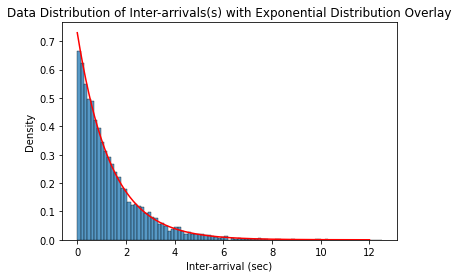

In [9]:
fig, ax = plt.subplots()
sns.histplot(data=df, x="Inter-arrival (sec)", ax=ax, stat='density')

# overlay exponential function
x = np.linspace(0, 12, 1000)
y = (1/beta) * np.exp(-x/beta)
sns.lineplot(x=x, y=y, ax=ax, color='red')

plt.title('Data Distribution of Inter-arrivals(s) with Exponential Distribution Overlay')
fig.savefig('./images/interarrival.png', bbox_inches='tight')

In [12]:
df["velocity (km/s)"].describe()
mu = 0.033353
std = 0.002505 # this is sample std already
min = 0.024006
max = 0.042084

In [13]:
# this is ok because it gives us the mu and std we want anyway
dist = stats.norm
args = dist.fit(df["velocity (km/s)"])
args
stats.kstest(df["velocity (km/s)"], dist.cdf, args)

KstestResult(statistic=0.006439789372512217, pvalue=0.7987384412525099)

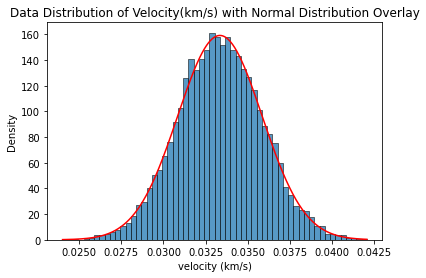

In [14]:
fig, ax = plt.subplots()
sns.histplot(data=df, x="velocity (km/s)", ax=ax, stat='density')

# overlay exponential function
x = np.linspace(min, max, 1000)
y = 1/(std*np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x-mu)/std) ** 2)
sns.lineplot(x=x, y=y, ax=ax, color='red')

plt.title("Data Distribution of Velocity(km/s) with Normal Distribution Overlay")
fig.savefig('./images/velocity.png')

In [13]:
df["Call duration (sec)"].describe()
beta = 109.835901 # this is uncentered
actual_beta = beta - 10.003951603252272

In [14]:
dist = stats.expon
args = dist.fit(df["Call duration (sec)"])
args
print(stats.kstest(df["Call duration (sec)"], dist.cdf, args))
# stats.kstest(df["Call duration (sec)"], expcdf, (beta,))
# print(args[1])
print(args)

KstestResult(statistic=0.005854123916584519, pvalue=0.8809285916372338)
(10.003951603252272, 99.83194913549542)


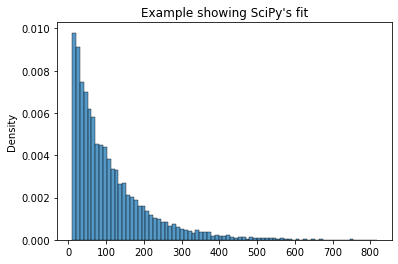

In [15]:
fig, ax = plt.subplots()
dist.rvs(loc=args[0], scale=args[1])
# sns.lineplot(x=dist.rvs(loc=args[0], scale=args[1], size=1000))
# plt.plot(dist.rvs(loc=args[0], scale=args[1], size=1000))
sns.histplot(data=dist.rvs(loc=args[0], scale=args[1], size=10000), ax=ax, stat='density', cumulative=False)
plt.title("Example showing SciPy's fit")
fig.savefig('./images/scipy_expon_example.png', bbox_inches='tight')

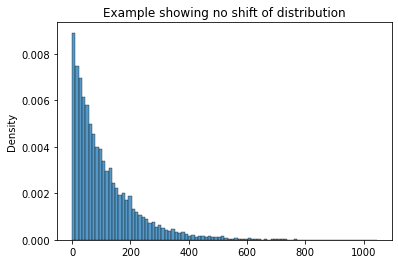

In [16]:
def random_duration(beta=109.835901):
    u = np.random.uniform()
    return -beta * np.log(1 - u)
fig, ax = plt.subplots()
data = [random_duration() for x in range(10000)]
sns.histplot(data=data, ax=ax, stat='density', cumulative=False)

plt.title('Example showing no shift of distribution')
fig.savefig('./images/manual_fit.png', bbox_inches='tight')

In [17]:
stats.kstest(df["Call duration (sec)"], expcdf, (beta,))

KstestResult(statistic=0.08722013653673563, pvalue=1.2257712860415087e-66)

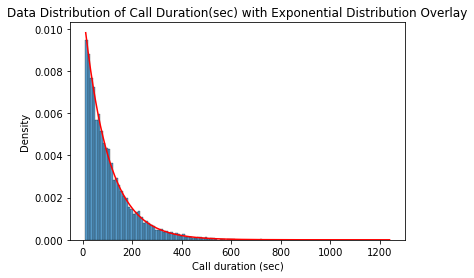

In [18]:
fig, ax = plt.subplots()

# overlay exponential function
x = np.linspace(12, 1240, 1000)
# y = (1/beta) * np.exp(-x/beta)
y = dist.pdf(x, loc=args[0], scale=args[1])
sns.lineplot(x=x, y=y, ax=ax, color='red')
# sns.lineplot(x=x, y=y2, ax=ax, color='green')

sns.histplot(data=df, x="Call duration (sec)", ax=ax, stat='density', cumulative=False)

plt.title('Data Distribution of Call Duration(sec) with Exponential Distribution Overlay')
fig.savefig('./images/callduration', bbox_inches='tight')

In [65]:
df["Base station "].describe()

count    10000.00000
mean        10.54220
std          5.78662
min          1.00000
25%          6.00000
50%         11.00000
75%         16.00000
max         20.00000
Name: Base station , dtype: float64

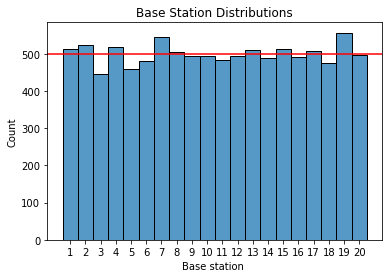

In [57]:
fig, ax = plt.subplots()

g = sns.histplot(data=df, x="Base station ", ax=ax, bins=20, discrete=True)
ax.axhline(1/20*10000, ls='-', color="red")

g.set_xticks(range(1, 21)) # <--- set the ticks first
g.set_xticklabels([str(i+1) for i in range(20)])

g.set_title('Base Station Distributions')
fig.savefig('./images/station_distributions.png')

In [43]:
f_exp = [1/20 * 10000 for x in range(20)]
f_obs = list(df["Base station "].value_counts().sort_index())

In [56]:
stats.chisquare(f_obs, f_exp, ddof=0)

Power_divergenceResult(statistic=25.656000000000002, pvalue=0.14006290765463547)